# EXPLORING THE RELATIONSHIP BETWEEN CHART EVENTS AND TIME TO ICU STAY
Note: this dataset is open-source, but restricted access. You must request access via https://mimic.physionet.org/gettingstarted/access/. I downloaded the dataset onto my personal computer and ran the analyses locally. Given HIPAA and privacy considerations, I will only show summary plots from data in the database (no patient-specific information will be displayed.

This notebook utilizes previously analyzed data that looks at chart events (e.g., vital signs, lab results, etc.) that occurred between hospital admission and ICU stay to test whether certain events/measurements may predict "imminent" (e.g., <=1 day) ICU stays.<br>

Briefly, data from the PATIENTS, ADMISSIONS, ICUSTAYS, PRESCRIPTIONS, and CHARTEVENTS databases are merged based on subject ID, hospital admission ID, and ICU stay (only drugs prescribed and chart events recorded after hospital admission time and before ICU stay were included in the dataframe). Finally, for each chart event across patients, I calculated the mean (+/- SEM) time from chart event to ICU admission to identify if there are any patterns in the types of chart events that imminently precede ICU stays.
<br>

The code to perform these analyses can be found on my github page (https://github.com/adamgiffordphd/imminent_icu_stays). The code includes functionality to parallel process the analysis to get through all ~330M rows in CHARTEVENTS.csv. This code was run on a private server with 40 processors.

In [1]:
import pickle
import glob
from numpy import append, unique, mean

In [2]:
# there are ~3300 pickle files that contain the data that is described above
# this cell finds the pickle files in the saved data directory
# drugs.pickle is a list of all unique drugs in the dataset
pckl_files = glob.glob("pickle/20200811/*.pickle")

In [3]:
# combine the data across pickle files
'''note: have to load and combine the data in batches because the resulting dataframe would be too
large. will do in batches of ~50, and compute running stats for visualization and assessment'''

for st_ix in range(0,len(pckl_files),50):
    # get the proper end ix
    if st_ix + 50 > len(pckl_files):
        en_ix = len(pckl_files)
    else:
        en_ix = st_ix + 50
    
    # load each pickle file, start anew for each batch, or append to existing otherwise
    for f_ix in range(st_ix,en_ix):
        if f_ix==st_ix:
            df = pickle.load(open(pckl_files[f_ix],'rb'))
        else:
            tmp = pickle.load(open(pckl_files[f_ix],'rb'))
            df = df.append(tmp)
    
    # for each batch, do some calculations on days from measurement to ICU
    df['SAMEDAY_CHRT_TO_ICU'] = df['DAYS_CHRT_TO_ICU'].apply(lambda x: int(x<=1))
    if st_ix==0: 
        df_bySubjAdICU = df.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).agg({'ITEMID': [list],'DAYS_CHRT_TO_ICU': [sum],'SAMEDAY_CHRT_TO_ICU': [sum]})
        df_bySubjAdICU[('SUBJECT_HADM_ICU_ID','count')] = df_bySubjAdICU[('ITEMID','list')].apply(lambda x: len(x))
        df_bySubjAdICU[('ITEMID','list')] = df_bySubjAdICU[('ITEMID','list')].apply(lambda x: unique(x))
    else:
        tmp = df.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).agg({'ITEMID': [list],'DAYS_CHRT_TO_ICU': [sum],'SAMEDAY_CHRT_TO_ICU': [sum]})
        tmp[('SUBJECT_HADM_ICU_ID','count')] = tmp[('ITEMID','list')].apply(lambda x: len(x))
        tmp[('ITEMID','list')] = tmp[('ITEMID','list')].apply(lambda x: unique(x))
        
        # check if ['SUBJECT_ID','HADM_ID','ICUSTAY_ID'] is in previous files and current file, combine if so
        for m_ix in tmp.index:
            if df_bySubjAdICU.index.isin([m_ix]).any():
                # append list and take unique
                df_bySubjAdICU.loc[m_ix][('ITEMID','list')] = unique(append(df_bySubjAdICU.loc[m_ix][('ITEMID','list')], tmp.loc[m_ix][('ITEMID','list')]))
                
                # sum the rest of the columns
                df_bySubjAdICU.loc[m_ix][('DAYS_CHRT_TO_ICU','sum')] = df_bySubjAdICU.loc[m_ix][('DAYS_CHRT_TO_ICU','sum')]+tmp.loc[m_ix][('DAYS_CHRT_TO_ICU','sum')]
                df_bySubjAdICU.loc[m_ix][('SAMEDAY_CHRT_TO_ICU','sum')] = df_bySubjAdICU.loc[m_ix][('SAMEDAY_CHRT_TO_ICU','sum')]+tmp.loc[m_ix][('SAMEDAY_CHRT_TO_ICU','sum')]
                df_bySubjAdICU.loc[m_ix][('SUBJECT_HADM_ICU_ID','count')] = df_bySubjAdICU.loc[m_ix][('SUBJECT_HADM_ICU_ID','count')]+tmp.loc[m_ix][('SUBJECT_HADM_ICU_ID','count')]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A valu

In [4]:
df_bySubjAdICU[('DAYS_CHRT_TO_ICU','mean')] = df_bySubjAdICU[('DAYS_CHRT_TO_ICU','sum')] / df_bySubjAdICU[('SUBJECT_HADM_ICU_ID','count')]
df_bySubjAdICU[('SAMEDAY_CHRT_TO_ICU','mean')] = df_bySubjAdICU[('SAMEDAY_CHRT_TO_ICU','sum')] / df_bySubjAdICU[('SUBJECT_HADM_ICU_ID','count')]

In [5]:
# for each event across subjects, create list of ('DAYS_CHRT_TO_ICU','mean') to calculate average
item_dict = dict()
for m_ix in df_bySubjAdICU.index:
    items = df_bySubjAdICU.loc[m_ix][('ITEMID','list')]
    for item in items:
        if item not in item_dict.keys():
            item_dict[item] = [df_bySubjAdICU.loc[m_ix][('DAYS_CHRT_TO_ICU','mean')]]
        else:
            item_dict[item].append([df_bySubjAdICU.loc[m_ix][('DAYS_CHRT_TO_ICU','mean')]])

In [6]:
# get mean +/- SEM for each chart event
import numpy as np
item_dict_mn = dict()
item_dict_sem = dict()
for key in item_dict.keys():
    item_dict_mn[key] = np.mean(item_dict[key])
    item_dict_sem[key] = np.std(item_dict[key])/np.sqrt(len(item_dict[key]))

In [7]:
# sort chart event IDs by increasing duration of event to ICU stay
item_ids = np.array([i for i in item_dict_mn.keys()])
item_mn_days = np.array([i for i in item_dict_mn.values()])
item_sem_days = np.array([i for i in item_dict_sem.values()])

In [8]:
ix = np.argsort(item_mn_days)
item_ids = item_ids[ix]
item_mn_days = item_mn_days[ix]
item_sem_days = item_sem_days[ix]

Text(0.5, 0, 'Item ID')

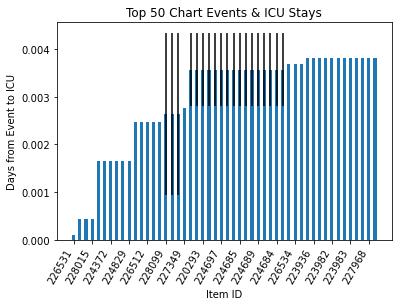

In [9]:
# let's look at the Top 50 events that most closely preceded an ICU stay
import matplotlib.pyplot as plt
plt.bar(x=range(0,50),
        height=item_mn_days[:50],width=0.5,
       yerr=item_sem_days[:50])
plt.title('Top 50 Chart Events & ICU Stays')
plt.ylabel('Days from Event to ICU')
xlabels = item_ids[:50]
plt.xticks(range(0,len(xlabels),3),xlabels[0::3],rotation=60,ha='right')
plt.xlabel('Item ID')

This figure shows the top 50 event items and their corresponding mean time to ICU stay from chart event time. <br>
NOTE: I realize something seems weird here. Will need to look into the analysis that I've done so far in more detail.

In [10]:
# what are the top 50 item ids?
# import patient info
import pandas as pd
data_dir = 'data/physionet.org/files/mimiciii/1.4/'
items_file = 'D_ITEMS.csv'
df_items = pd.read_csv(data_dir + items_file)

In [11]:
# top 50 labels identifying item ids
labels = []
for item in item_ids[:50]:
    labels.append(df_items.loc[df_items['ITEMID'] == item]['LABEL'])

In [12]:
labels

[11885    Admission Weight (lbs.)
 Name: LABEL, dtype: object,
 11055    22 G Infiltration Scale
 Name: LABEL, dtype: object,
 9838    22 Gauge Site Appear
 Name: LABEL, dtype: object,
 11054    22 G Phlebitis Scale
 Name: LABEL, dtype: object,
 11554    Trach Tube Manufacturer
 Name: LABEL, dtype: object,
 10737    Sputum Amount
 Name: LABEL, dtype: object,
 10736    Sputum Source
 Name: LABEL, dtype: object,
 10187    Sputum Color
 Name: LABEL, dtype: object,
 10186    Sputum Consistency
 Name: LABEL, dtype: object,
 11553    Trach Tube Type
 Name: LABEL, dtype: object,
 11503    Arterial Blood Pressure diastolic
 Name: LABEL, dtype: object,
 11502    Arterial Blood Pressure systolic
 Name: LABEL, dtype: object,
 11875    Admission Weight (Kg)
 Name: LABEL, dtype: object,
 10408    Cuff Pressure
 Name: LABEL, dtype: object,
 11504    Arterial Blood Pressure mean
 Name: LABEL, dtype: object,
 11976    18 Gauge placed in the field
 Name: LABEL, dtype: object,
 9959    18 Gauge Dressing

Some general patterns emerge when looking at the categories of lab events that are related to the shortest durations between measurement and admission to ICU. The majority of the lab events above fall into the general category of "vital signs" (e.g., weight, blood pressure, HR, respiration, blood ion measurements, assessment of body extremeties). These could reflect true indicators of necessary trips to the ICU, or they could simply reflect vital signs measurements taken as (but slightly before) these patients were already being transferred to the ICU. To test for this, I will need to look at the relative proportions that these chart events show up for patients being quickly admitted to the ICU vs. for patients that are not. This would provide an estimate of the "added influence" these measures provide to predicting imminent ICU stays over the general prevalence.

Text(0.5, 0, 'Item ID')

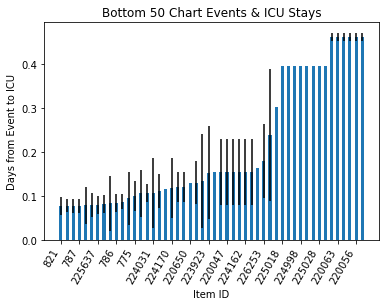

In [13]:
# what about the bottom 50 item ids?
plt.bar(x=range(0,50),
        height=item_mn_days[-50:],width=0.5,
       yerr=item_sem_days[-50:])
plt.title('Bottom 50 Chart Events & ICU Stays')
plt.ylabel('Days from Event to ICU')
xlabels = item_ids[-50:]
plt.xticks(range(0,len(xlabels),3),xlabels[0::3],rotation=60,ha='right')
plt.xlabel('Item ID')

NOTE: It seems that all of the chart events here are associated with measurements taken within 1 day of ICU admission (i.e., "imminent admissions"). This is likely due to the pre-selection of patients, hospital admission ID, and ICU stay ID that I carried over from the previous workbook. I will need to go through this again and look at chart events irrespective of the other factors I previously selected for. All that being said, this analysis does show that certain chart events are much more likely to occur close in time to an ICU admission, whereas certain others are less likely, suggesting that there is useful information in the kinds of charted events and their relation to ICU stays.

In [14]:
# get the bottom 50 labels
bot_labels = []
for item in item_ids[-50:]:
    bot_labels.append(df_items.loc[df_items['ITEMID'] == item]['LABEL'])
bot_labels

[1559    Magnesium (1.6-2.6)
 Name: LABEL, dtype: object,
 1520    BUN (6-20)
 Name: LABEL, dtype: object,
 1527    Chloride (100-112)
 Name: LABEL, dtype: object,
 1526    Carbon Dioxide
 Name: LABEL, dtype: object,
 50    Pain Level/Response
 Name: LABEL, dtype: object,
 962    Pt./Family Informed
 Name: LABEL, dtype: object,
 10515    Differential-Atyps
 Name: LABEL, dtype: object,
 11487    LDH
 Name: LABEL, dtype: object,
 9305    Skin Integrity
 Name: LABEL, dtype: object,
 1525    Calcium (8.4-10.2)
 Name: LABEL, dtype: object,
 1523    CPK
 Name: LABEL, dtype: object,
 9934    History of falling (within 3 mnths)
 Name: LABEL, dtype: object,
 1514    Amylase
 Name: LABEL, dtype: object,
 1474    Untoward Effect
 Name: LABEL, dtype: object,
 1524    CPK/MB
 Name: LABEL, dtype: object,
 9308    Edema Location
 Name: LABEL, dtype: object,
 759    Total Bili (0-1.5)
 Name: LABEL, dtype: object,
 1456    Trach Care
 Name: LABEL, dtype: object,
 9317    MDI #1 Drug
 Name: LABEL, dtype

In contrast to the top 50 chart events above, the bottom 50 chart events were more likely to be associated with alarms for automatic monitoring of vitals (e.g., blood pressure, heart rate), treatment of incisions, and measurements of certain other vitals (e.g., magnesium, CO2, etc.).